In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits

from gmagaox.math_module import xp, _scipy, ensure_np_array
import gmagaox.gmagaox as gmagaox
from gmagaox import optics, opds
from gmagaox import utils
from gmagaox.imshows import *

from importlib import reload

import poppy

import logging
import sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False
poppy_log.disabled = True

zemax_pupil_diams = {
    'fsm-pp':16.1887*u.mm,
    'ADC-pp':50.3325*u.mm, 
    'woofer-pp':87.6977*u.mm, 
    'tweeter-pp':73.7536*u.mm, 
    'focal plane SM - pp':12.1121*u.mm, 
    'Apodizer-pp':24.2002*u.mm, 
    'Lyot-pp':25.1939*u.mm, 
}

tweeter_pupil_diam = 72.88629845263029*u.mm
lyot_pupil_diam = 25.204568699366828*u.mm


In [3]:
(26.63-26.46)/26.63

0.006383777694329634

In [65]:
!nvidia-smi

Mon Feb 26 18:39:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   34C    P0             63W /  300W |   52724MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
8192/2540

3.2251968503937007

In [2]:
reload(gmagaox)
reload(opds)

# model = gmagaox.MODEL(npix=2540, oversample=4096/2540)
model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model.use_opds = True
# model.use_dm_surfaces = False

model.end_at_lyot = True

lyot_wf = model.calc_wf()



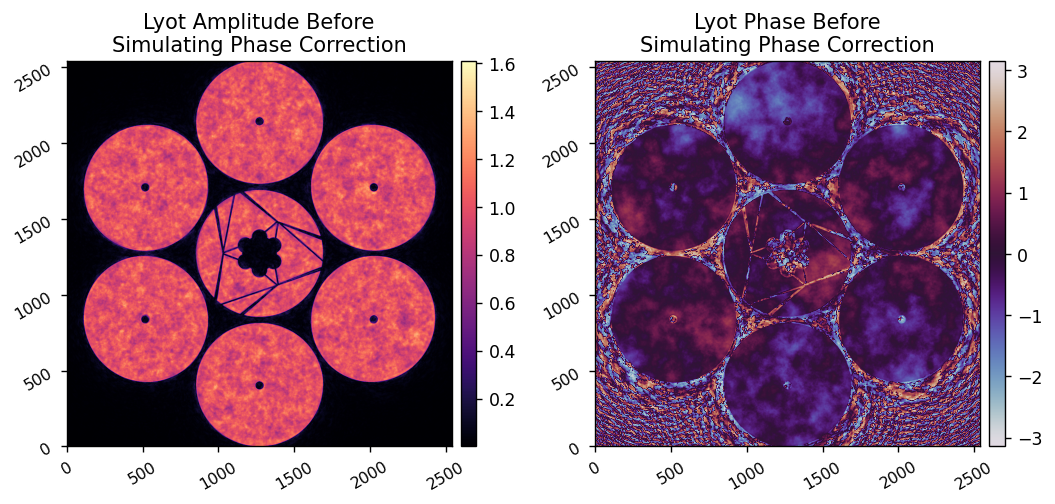

In [3]:
lyot_amp = utils.pad_or_crop(xp.abs(lyot_wf), model.npix)
lyot_phs = utils.pad_or_crop(xp.angle(lyot_wf), model.npix)

imshow2(lyot_amp, lyot_phs, 
        'Lyot Amplitude Before\nSimulating Phase Correction',
        'Lyot Phase Before\nSimulating Phase Correction',
        cmap2='twilight')

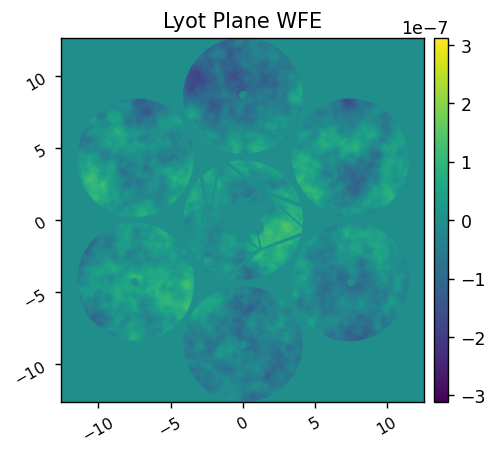

In [4]:
lyot_opd = lyot_phs * model.wavelength.to_value(u.m)/(2*np.pi) * model.pupil_mask
lyot_pixelscale = lyot_pupil_diam/(model.npix*u.pix)
imshow1(lyot_opd, 'Lyot Plane WFE', cmap='viridis', pxscl=lyot_pixelscale)

# utils.save_fits('gmagaox/data/lyot_opd.fits', lyot_opd, header={'PIXELSCL':lyot_pixelscale.to_value(u.m/u.pix)})

In [5]:
Nacts = 60
xfp = model.psf_pixelscale_lamD*(xp.linspace(-model.N//2, model.N//2-1, model.N) + 1/2)
xfp,yfp = xp.meshgrid(xfp,xfp)
rfp = xp.sqrt(xfp**2 + yfp**2)

filter = xp.zeros_like(lyot_wf)
filter[rfp<90] = 1



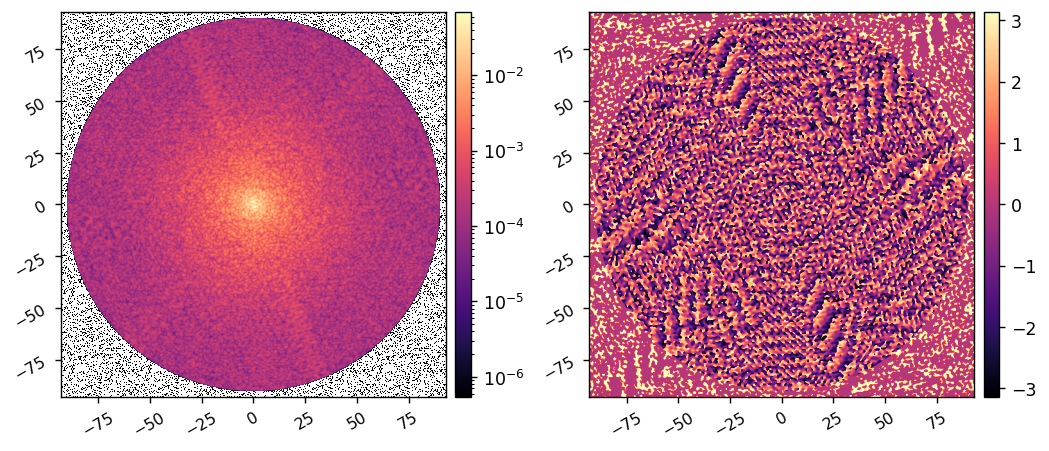

In [7]:
# sfs = xp.fft.fftshift(xp.fft.fft2(xp.fft.fftshift(lyot_wf)))
sfs = xp.fft.fftshift(xp.fft.fft2(xp.fft.fftshift(utils.pad_or_crop(lyot_opd, model.N))))
sfs *= filter
imshow2(xp.abs(sfs), xp.angle(sfs), npix=600, pxscl=model.psf_pixelscale_lamD, lognorm1=True)

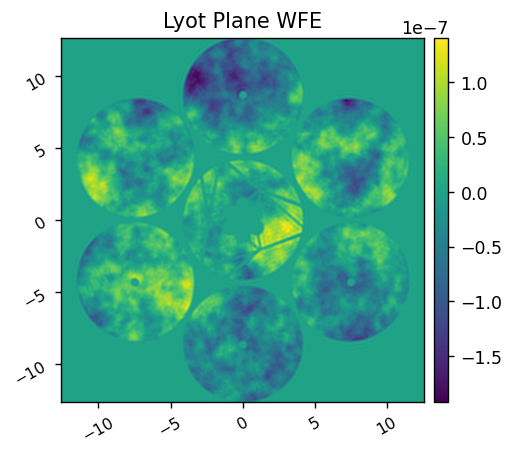

Saved data to:  gmagaox/data/filtered_lyot_opd.fits


In [11]:
filtered_lyot_opd = utils.pad_or_crop(xp.fft.fftshift(xp.fft.ifft2(xp.fft.fftshift(sfs))).real, model.npix)
lyot_pixelscale = lyot_pupil_diam/(model.npix*u.pix)
imshow1(filtered_lyot_opd, 'Lyot Plane WFE', cmap='viridis', pxscl=lyot_pixelscale)

utils.save_fits('gmagaox/data/filtered_lyot_opd.fits', filtered_lyot_opd, 
                header={'PIXELSCL':lyot_pixelscale.to_value(u.m/u.pix)})

In [35]:

filtered_lyot_wf = xp.fft.fftshift(xp.fft.ifft2(xp.fft.fftshift(sfs)))

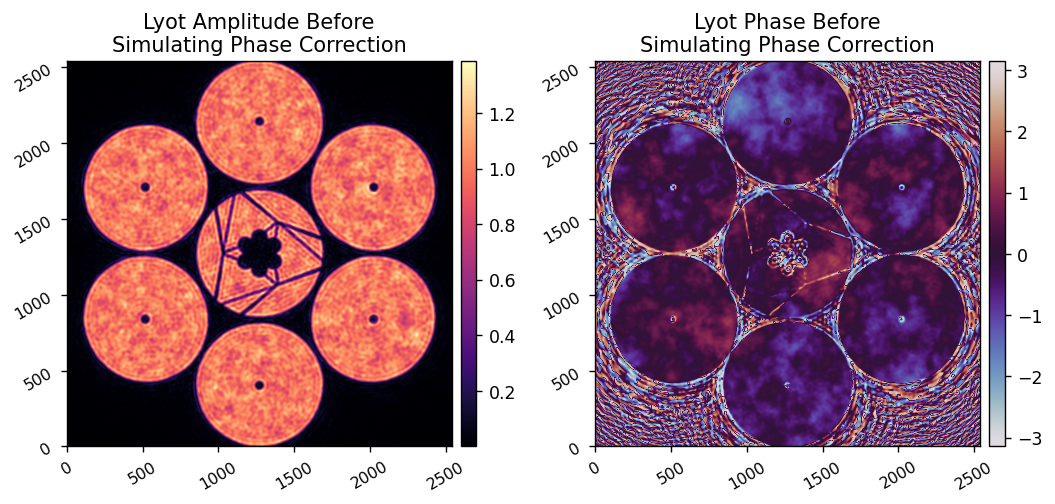

In [36]:
filtered_lyot_amp = utils.pad_or_crop(xp.abs(filtered_lyot_wf), model.npix)
filtered_lyot_phs = utils.pad_or_crop(xp.angle(filtered_lyot_wf), model.npix)

imshow2(filtered_lyot_amp, filtered_lyot_phs, 
        'Lyot Amplitude Before\nSimulating Phase Correction',
        'Lyot Phase Before\nSimulating Phase Correction',
        cmap2='twilight')

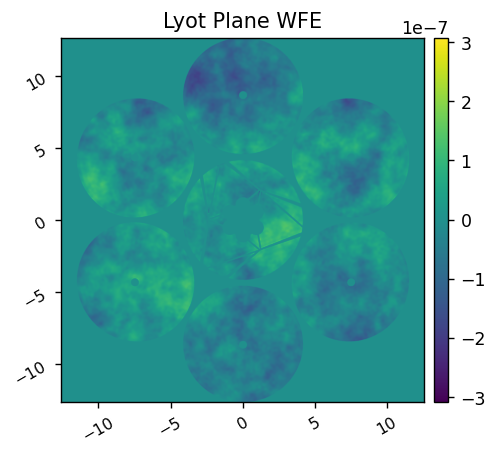

Saved data to:  gmagaox/data/filtered_lyot_opd.fits


In [47]:
filtered_lyot_opd = filtered_lyot_phs * model.wavelength.to_value(u.m)/(2*np.pi) * model.pupil_mask
lyot_pixelscale = lyot_pupil_diam/(model.npix*u.pix)
imshow1(filtered_lyot_opd, 'Lyot Plane WFE', cmap='viridis', pxscl=lyot_pixelscale)

utils.save_fits('gmagaox/data/filtered_lyot_opd.fits', filtered_lyot_opd, 
                header={'PIXELSCL':lyot_pixelscale.to_value(u.m/u.pix)})

In [46]:
type(filtered_lyot_opd), type(lyot_opd)

(cupy.ndarray, cupy.ndarray)

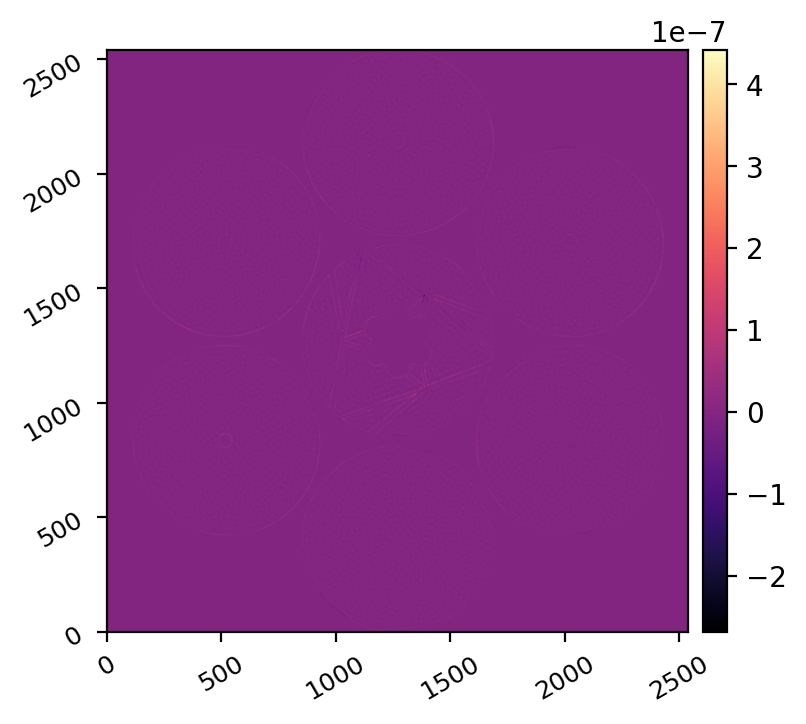

In [45]:
imshow1(filtered_lyot_opd-lyot_opd, dpi=200)

# Try applying the phase correction

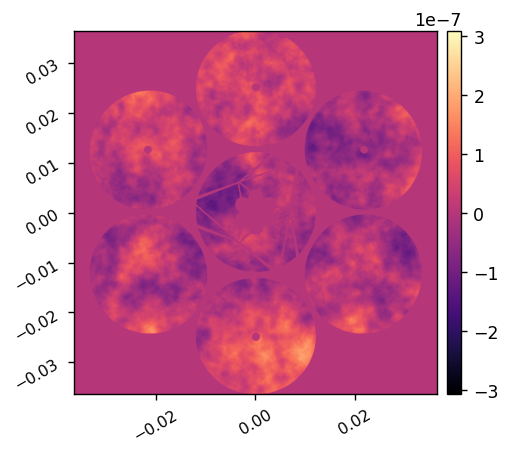

In [49]:
lyot_opd = fits.getdata('gmagaox/data/lyot_opd.fits')
lyot_opd = fits.getdata('gmagaox/data/filtered_lyot_opd.fits')
lyot_pixelscale = fits.getheader('gmagaox/data/lyot_opd.fits')['PIXELSCL'] * u.m/u.pix

tweeter_lyot_mag = (tweeter_pupil_diam/lyot_pupil_diam).decompose().value
tweeter_pixelscale = lyot_pixelscale*tweeter_lyot_mag

LYOT_WFE = poppy.ArrayOpticalElement(opd=-xp.rot90(xp.rot90(lyot_opd)), pixelscale=tweeter_pixelscale)
imshow1(LYOT_WFE.opd, pxscl=LYOT_WFE.pixelscale)

In [50]:
reload(gmagaox)
reload(opds)

# model = gmagaox.MODEL(npix=2540, oversample=4096/2540)
model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model.use_opds = True
model.use_dm_surfaces = True

model.end_at_lyot = True

model.use_lyot_opd = True
model.LYOT_WFE = LYOT_WFE

lyot_wf = model.calc_wf()

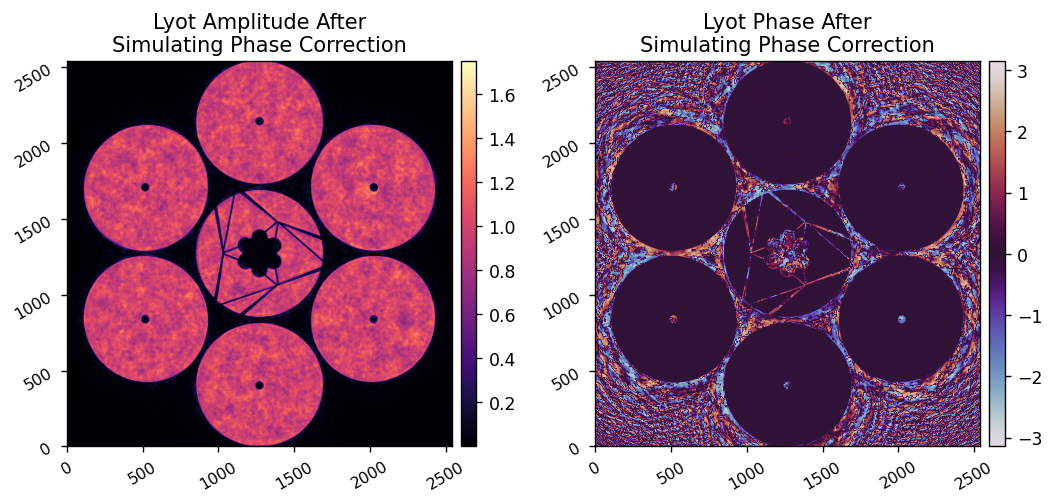

In [51]:
corrected_lyot_amp = utils.pad_or_crop(xp.abs(lyot_wf), model.npix)
corrected_lyot_phs = utils.pad_or_crop(xp.angle(lyot_wf), model.npix)

imshow2(corrected_lyot_amp, corrected_lyot_phs, 
        'Lyot Amplitude After\nSimulating Phase Correction',
        'Lyot Phase After\nSimulating Phase Correction',
        cmap2='twilight')

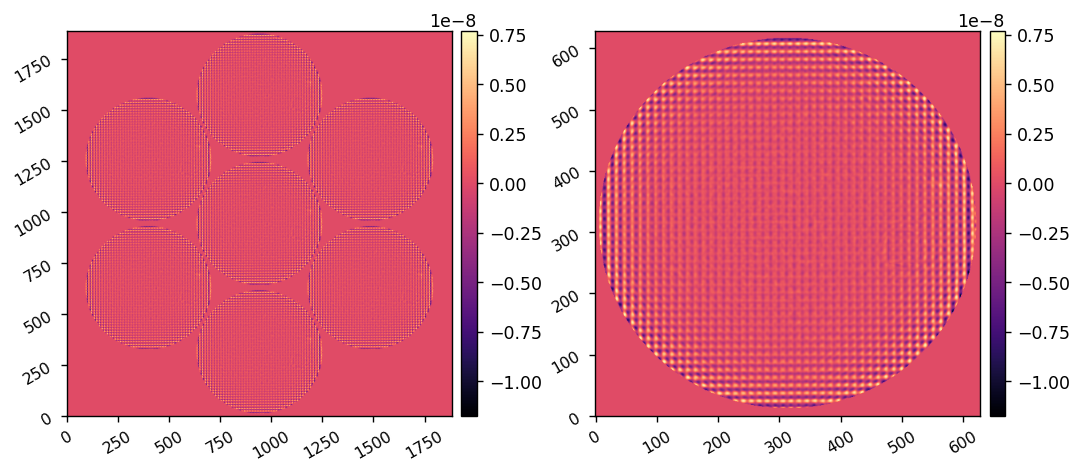

In [14]:
model.tweeter_surf.opd *= 2
model.ncpDM_surf.opd *= 2
imshow2(model.tweeter_surf.opd, model.ncpDM_surf.opd)

In [53]:
reload(gmagaox)
model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model.use_opds = True
model.use_dm_surfaces = True

model.use_lyot_opd = True
model.LYOT_WFE = LYOT_WFE

fp_wf, fp_pixelscale = model.calc_wf(pixelscale=True)

In [54]:
from matplotlib.patches import Circle
airy_radius = 26.63*u.um
imshow1(xp.abs(fp_wf)**2, 'Final Image After Correction',
        lognorm=True, 
        npix=256,
        pxscl=fp_pixelscale.to(u.mm/u.pix),
        patches=[Circle((fp_pixelscale.to_value(u.mm/u.pix)/2,fp_pixelscale.to_value(u.mm/u.pix)/2), 
                         airy_radius.to_value(u.mm), fill=False, color='cyan')],
        )

NameError: name 'fp_wf' is not defined

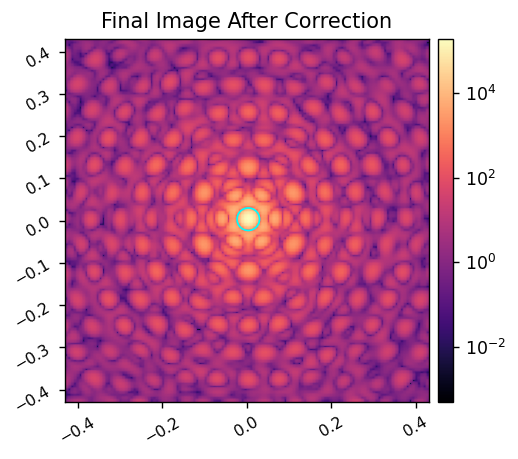

In [57]:
from matplotlib.patches import Circle
airy_radius = 26.63*u.um
imshow1(xp.abs(fp_wf_2)**2, 'Final Image After Correction',
        lognorm=True,
        npix=128,
        pxscl=fp_pixelscale.to(u.mm/u.pix),
        patches=[Circle((fp_pixelscale.to_value(u.mm/u.pix)/2,fp_pixelscale.to_value(u.mm/u.pix)/2), 
                         airy_radius.to_value(u.mm), fill=False, color='cyan')],
        )

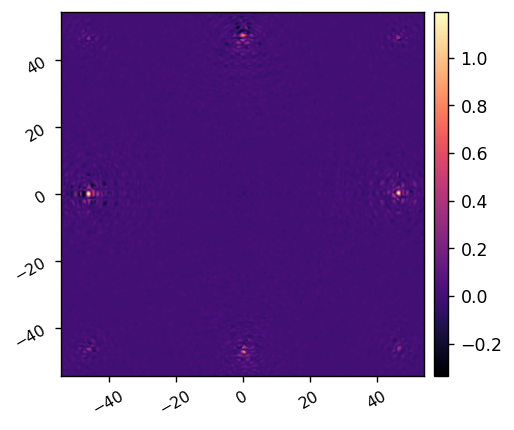

In [33]:
imshow1(xp.abs(fp_wf_2)-xp.abs(fp_wf), npix=350, pxscl=model.psf_pixelscale_lamD )